In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gshaz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gshaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
data = pd.read_csv(r'C:\Users\gshaz\OneDrive\Masaüstü\Machine Learning Bootcamp\Proje\news.csv',nrows= 500)

Dropping Na values and correcting data types

In [43]:
print(data[["Description","Body"]].isna().value_counts())
data = data.dropna(subset=["Description","Body"])
print(data[["Description","Body"]].isna().value_counts())
data["Description"] = data["Description"].astype(str)
data["Body"] = data["Body"].astype(str)
data = data.reset_index(drop=True)

Description  Body 
False        False    499
True         False      1
dtype: int64
Description  Body 
False        False    499
dtype: int64


In [44]:
news = data[["ID", "Description", "Body"]]
print(news.isna().sum())

ID             0
Description    0
Body           0
dtype: int64


In [45]:

print(news.dtypes)

ID              int64
Description    object
Body           object
dtype: object


In [46]:
custom_stopwords = [
    "a", "an", "the", "in", "on", "at", "to", "for", "of", "by",
    "with", "as", "and", "but", "or", "from", "is", "was", "were",
    "it", "that", "this", "these", "those", "such", "he", "she", "they",
    "we", "you", "me", "him", "her", "us", "them", "i", "your", "his",
    "their", "its", "our", "be", "are", "will", "have", "has", "had",
    "do", "does", "doing", "done", "get", "gets", "got", "getting",
    "been", "am", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
    "doesn't", "don't", "didn't", "won't", "wouldn't", "shouldn't", "mustn't"
    # Add any additional words specific to your analysis
]

stop_words = set(stopwords.words("english") + custom_stopwords)

In [47]:
def get_ngrams(input_list, n):
#creates list of double triple... word groups
    return list(zip(*[input_list[i:] for i in range(n)]))

In [48]:
def frequency_calculator(text):
    words = word_tokenize(text)
    #remove numbers and turn strings into lower case
    filtered_words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]
    #calculate the recurrence of words
    word_freq = FreqDist(filtered_words)
    filtered_words = [word for word in filtered_words if word_freq[word] > 1]
    word_freq_filtered = FreqDist(filtered_words)
    #create ngrams for 2-4 days 
    ngrams = {}
    for i in range(2,5):
        ngrams[i] = get_ngrams(filtered_words,i)
    #calculate recurrence
    ngrams_freq = {}
    for key,value in ngrams.items():
        ngrams_freq[key] = Counter(value)
    
    repeated_ngrams = {}
    for key, ngram_counter in ngrams_freq.items():
        repeated_ngrams[key] = {ngram: count for ngram, count in ngram_counter.items() if count > 1}
    
    return word_freq_filtered,repeated_ngrams

In [49]:
most_common = pd.DataFrame(columns = ["description_word_freq","description_ngrams_freq","body_word_freq","body_ngrams_freq"])
for index,row in news.iterrows():
    description = row[1]
    body = row[2]
    #adding most commmon words, ngrams for news body and descriotion
    description_words_fdist, description_ngrams_counter = frequency_calculator(description)
    description_word_common = description_words_fdist.most_common(3)
    
    
    description_ngrams_common = Counter(description_ngrams_counter[2]).most_common(3)
    description_ngrams_common.extend(Counter(description_ngrams_counter[3]).most_common(3))
    description_ngrams_common.extend(Counter(description_ngrams_counter[4]).most_common(3))

    body_words_fdist, body_ngrams_counter = frequency_calculator(body)
    body_words_common = body_words_fdist.most_common(10)

    
    body_ngrams_common = Counter(body_ngrams_counter[2]).most_common(4)
    body_ngrams_common.extend(Counter(body_ngrams_counter[3]).most_common(4))
    body_ngrams_common.extend(Counter(body_ngrams_counter[4]).most_common(4))
    
    new_row = {"description_word_freq" : description_word_common,"description_ngrams_freq": description_ngrams_common, "body_word_freq" : body_words_common, "body_ngrams_freq" : body_ngrams_common}
    most_common.loc[len(most_common)] = new_row

In [50]:
print(most_common.to_string())

                              description_word_freq                                                                                                                                                                                                                         description_ngrams_freq                                                                                                                                               body_word_freq                                                                                                                                                                                                                                                                                                                                                                                                                                                        body_ngrams_freq
0                                                []                                            

In [51]:
# merging data of news and data of frequencies
merged = pd.merge(data, most_common, left_index=True, right_index=True)

In [52]:
print(merged.head(1))

   ID                                              Title  \
0   1  Candy factory didn't evacuate concerned worker...   

                                         Description  \
0  An eastern Pennsylvania candy factory didn’t e...   

                                                Body  \
0  An eastern Pennsylvania candy factory didn’t e...   

                                            Keywords Theme  \
0  accident investigations, accidents, accidents,...    us   

                                                Link description_word_freq  \
0  https://edition.cnn.com/2023/10/06/us/pennsylv...                    []   

  description_ngrams_freq                                     body_word_freq  \
0                      []  [(said, 7), (palmer, 7), (reading, 6), (gas, 5...   

                                    body_ngrams_freq  
0  [((explosion, march), 2), ((candy, maker), 2),...  


In [53]:
print(merged.columns)

Index(['ID', 'Title', 'Description', 'Body', 'Keywords', 'Theme', 'Link',
       'description_word_freq', 'description_ngrams_freq', 'body_word_freq',
       'body_ngrams_freq'],
      dtype='object')


In [54]:
body_word_freq = merged["body_word_freq"]
print(body_word_freq)
body_ngrams_freq = merged["body_ngrams_freq"]
print(body_ngrams_freq)


0      [(said, 7), (palmer, 7), (reading, 6), (gas, 5...
1      [(said, 10), (university, 9), (friday, 6), (fo...
2      [(kruger, 7), (davis, 7), (said, 7), (philadel...
3      [(said, 10), (funeral, 9), (home, 9), (keller,...
4      [(said, 10), (children, 9), (court, 9), (day, ...
                             ...                        
494    [(mass, 11), (biden, 10), (shooting, 9), (shoo...
495    [(trump, 18), (board, 17), (garland, 16), (sai...
496    [(trump, 39), (raffensperger, 32), (call, 19),...
497    [(trump, 77), (said, 35), (biden, 21), (first,...
498    [(trump, 59), (desantis, 22), (claim, 20), (sa...
Name: body_word_freq, Length: 499, dtype: object
0      [((explosion, march), 2), ((candy, maker), 2),...
1      [((morgan, state), 5), ((state, university), 4...
2      [((marshmond, said), 5), ((davis, custody), 2)...
3      [((funeral, home), 9), ((keller, said), 6), ((...
4      [((day, care), 7), ((care, center), 6), ((herr...
                             ...       

In [55]:
# calculating the total recurrence of words in all texts
word_vocab = set([item[0] for item in body_word_freq] )
word_counts = {}
for word, count in word_vocab:
    if word in word_counts:
        word_counts[word] += count
    else:
        word_counts[word] = count
word_counts = sorted(word_counts.items(), key = lambda x:x[1])
word_counts = dict(word_counts)

ngram_vocab = set([item[0] for item in body_ngrams_freq])
ngram_counts = {}
# calculating the total recurrence of ngrams in all texts
for ngram, count in ngram_vocab:
    if ngram in ngram_counts:
        ngram_counts[ngram] += count
    else : 
        ngram_counts[ngram] = count

In [56]:
in_ngram_count = {}
#calculating words total  reappearance of words in ngrams
for ngram,count in ngram_counts.items():
   
    for word in word_counts:
        if word in ngram:
            if word in in_ngram_count:
                in_ngram_count[word] += count
            else:
                in_ngram_count[word] = count
#calculating ratio of words appearence in ngrams to all appearence 
ngram_ratio = {}
for word,count in in_ngram_count.items():
    ngram_ratio[word] = (count/word_counts[word],word_counts[word])


In [57]:
ngram_ratio = {key: values for key, values in ngram_ratio.items() if values[0] <= 1}
print(ngram_ratio.items())

dict_items([('ukraine', (0.12554112554112554, 231)), ('gas', (1.0, 9)), ('phillips', (0.2962962962962963, 27)), ('said', (0.4553846153846154, 325)), ('president', (0.6666666666666666, 72)), ('taiwan', (0.11428571428571428, 35)), ('china', (0.13372093023255813, 172)), ('game', (0.2727272727272727, 22)), ('university', (0.9375, 16)), ('blood', (0.5714285714285714, 7)), ('refugee', (0.375, 16)), ('gum', (0.21052631578947367, 19)), ('kelce', (0.34782608695652173, 23)), ('says', (0.43333333333333335, 30)), ('iran', (0.6363636363636364, 11)), ('europe', (0.75, 4)), ('long', (0.6666666666666666, 15)), ('club', (0.25, 8)), ('azerbaijan', (0.05084745762711865, 59)), ('comstock', (0.7272727272727273, 22)), ('space', (0.375, 16)), ('military', (0.17073170731707318, 41)), ('penn', (0.16666666666666666, 12)), ('jobs', (0.12, 25)), ('ftx', (0.125, 24)), ('fentanyl', (0.5, 12)), ('government', (0.40625, 64)), ('admissions', (0.5555555555555556, 9)), ('democrats', (0.5263157894736842, 19)), ('open', (

In [58]:
ngram_ratio = dict(sorted(ngram_ratio.items(), key=lambda item: item[1][1]))
print(ngram_ratio)

{'gellar': (0.6666666666666666, 3), 'europe': (0.75, 4), 'bilson': (0.5, 4), 'caine': (1.0, 4), 'mandela': (0.4, 5), 'elba': (0.4, 5), 'lions': (0.4, 5), 'barrymore': (0.5, 6), 'boss': (0.3333333333333333, 6), 'exorcist': (0.5, 6), 'live': (0.3333333333333333, 6), 'mitzvah': (0.8333333333333334, 6), 'match': (0.3333333333333333, 6), 'one': (0.5, 6), 'information': (0.6666666666666666, 6), 'blood': (0.5714285714285714, 7), 'open': (0.7142857142857143, 7), 'ukrainian': (0.5714285714285714, 7), 'models': (0.5714285714285714, 7), 'night': (0.7142857142857143, 7), 'nun': (0.5714285714285714, 7), 'season': (0.42857142857142855, 7), 'miami': (0.42857142857142855, 7), 'club': (0.25, 8), 'mgm': (0.5, 8), 'prince': (0.25, 8), 'shaddock': (0.375, 8), 'indonesia': (0.375, 8), 'tour': (0.625, 8), 'gas': (1.0, 9), 'admissions': (0.5555555555555556, 9), 'usa': (0.5555555555555556, 9), 'diesel': (0.3333333333333333, 9), 'drake': (0.4444444444444444, 9), 'clinton': (0.4444444444444444, 9), 'war': (0.3,

In [59]:
#Changing Data into dataframe format
words = list(ngram_ratio.keys())
ratios = []
counts = []

for key, (x, y) in ngram_ratio.items():
    ratios.append(x)
    counts.append(y)

In [60]:
ngram_df = pd.DataFrame(data= {"word" : words, "ratio" : ratios, "count" : counts})
print(ngram_df)


        word     ratio  count
0     gellar  0.666667      3
1     europe  0.750000      4
2     bilson  0.500000      4
3      caine  1.000000      4
4    mandela  0.400000      5
..       ...       ...    ...
130    biden  0.494048    168
131    china  0.133721    172
132  ukraine  0.125541    231
133     said  0.455385    325
134    trump  0.020873    527

[135 rows x 3 columns]


Plotting 

C:\Users\gshaz\AppData\Local\Temp\ipykernel_14604\2017481545.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ngram_df['word'], rotation=90,fontsize=4)


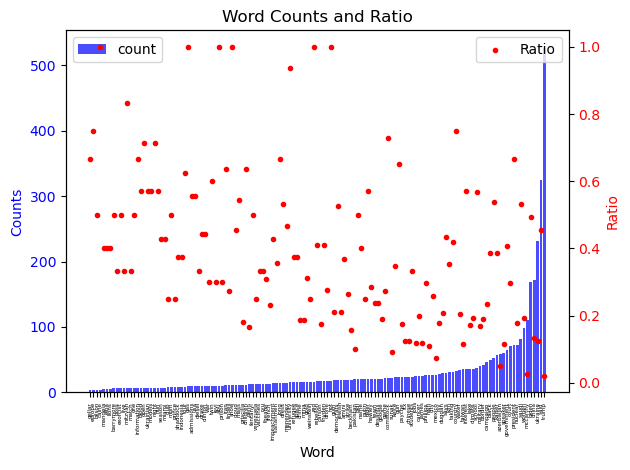

In [61]:
fig, ax1 = plt.subplots()
ax1.bar(ngram_df['word'], ngram_df['count'], color='b', alpha=0.7, label='count')
ax1.set_xlabel('Word')
ax1.set_ylabel('Counts', color='b')
ax1.set_xticklabels(ngram_df['word'], rotation=90,fontsize=4)
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.scatter(ngram_df['word'], ngram_df['ratio'], color='r', marker='.', label='Ratio')
ax2.set_ylabel('Ratio', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Word Counts and Ratio')
plt.tight_layout()
plt.show()

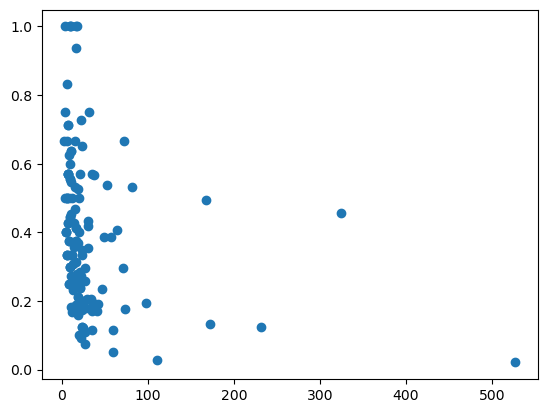

In [62]:
plt.scatter(ngram_df['count'],ngram_df['ratio'])

In [63]:
plot_df = ngram_df[ngram_df.iloc[:,2] <300]


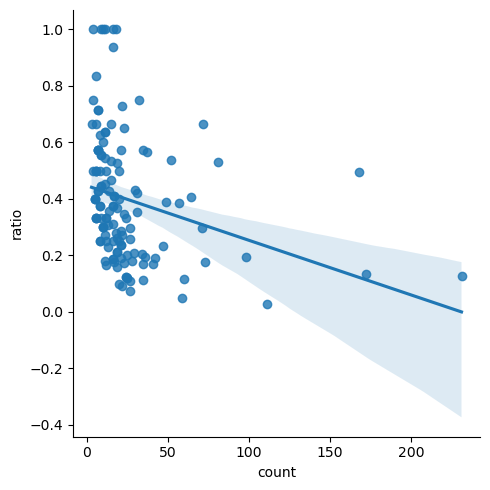

In [64]:
sns.lmplot(x="count",y="ratio",data=plot_df)

In [74]:
print(ngram_df['ratio'].corr(ngram_df['count']))
new_df = ngram_df.copy(deep=True)

-0.23662468151359378


In [75]:
new_df['ratio'] = np.log10(new_df['ratio'])
new_df['count'].corr(new_df['ratio'])

-0.40956469368719967